Experiment with SwinUNETR v2 model

In [1]:
import os
import time
import datetime

import matplotlib.pyplot as plt
import numpy as np

import datasets as D
import torch
from torch.utils.tensorboard import SummaryWriter

from monai.inferers import sliding_window_inference

from monai.networks.nets import SwinUNETR

from monai.config import print_config
from monai import transforms, data, losses, optimizers, metrics
from monai.utils import set_determinism
print_config()

MONAI version: 1.3.0
Numpy version: 1.26.0
Pytorch version: 2.1.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: c:\Users\<username>\miniforge3\envs\p310-torch\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.22.0
scipy version: 1.11.3
Pillow version: 10.0.1
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.1
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.1.3
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the

## Setup data path and parameters

In [2]:
PROJECT_DATASET_DIR = "D:\\Files\\Projects\\MAIA\\UdG\\MISA\\Project"

DATA_DIR = PROJECT_DATASET_DIR + "\\dataset"

EXP_NAME = "exp02-SwinUNETR_v2" # name of the experiment

BATCH_SIZE_TRAIN = 4
BATCH_SIZE_INFER = 2

LR = 2e-4
PATIENCE = 0 # set 0 to disable

NUM_CLASSES = 4

In [3]:
EXP_ID = EXP_NAME+"-"+time.strftime("%Y%m%d_%H_%M_%S", time.localtime(time.time()))

root_dir = PROJECT_DATASET_DIR + "\\experiments\\" + EXP_ID
print(root_dir)

D:\Files\Projects\MAIA\UdG\MISA\Project\experiments\exp02-SwinUNETR_v2-20231230_21_03_40


In [4]:
# make directory
if not os.path.exists(root_dir):
    os.makedirs(root_dir)

In [5]:
tb_writer = SummaryWriter(root_dir)

## Set seed

In [3]:
set_determinism(seed=42)

## Setup transforms

In [4]:
# dataset info
IMG_SIZE = (256, 128, 256)
BG_LABEL = 0
CSF_LABEL = 1
GM_LABEL = 2
WM_LABEL = 3

ROI = (96, 96, 96)
NUM_PATCHES_PER_IMAGE = 4
NUM_PATCHES_PER_ITER = 2

In [5]:
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        transforms.ToTensord(keys=["image", "label"]),
        transforms.EnsureTyped(keys=["image", "label"], track_meta=True),
        transforms.NormalizeIntensityd(keys="image", nonzero=True),
        transforms.Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
       
        transforms.CropForegroundd(
            allow_smaller=True,
            keys=["image", "label"],
            source_key="image",
            k_divisible=[ROI[0], ROI[1], ROI[2]],
        ),
        transforms.RandCropByLabelClassesd(
            keys=["image", "label"],
            label_key="label",
            spatial_size=[ROI[0], ROI[1], ROI[2]],
            num_classes=NUM_CLASSES,
            num_samples=NUM_PATCHES_PER_IMAGE,
        ),
        transforms.RandFlipd(keys=["image", "label"], prob=0.2, spatial_axis=0),
        transforms.RandFlipd(keys=["image", "label"], prob=0.2, spatial_axis=1),
        transforms.RandFlipd(keys=["image", "label"], prob=0.2, spatial_axis=2),
        transforms.RandRotate90d(keys=["image", "label"], prob=0.2, max_k=3),
        transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=0.1),
        transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=0.1),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        transforms.ToTensord(keys=["image", "label"]),
        transforms.EnsureTyped(keys=["image", "label"], track_meta=True),
        transforms.NormalizeIntensityd(keys="image", nonzero=True),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"], ensure_channel_first=True),
        transforms.ToTensord(keys=["image"]),
        transforms.EnsureTyped(keys=["image"], track_meta=True),
        transforms.NormalizeIntensityd(keys="image", nonzero=True),
    ]
)

## Load the dataset

In [6]:
json_file_path = os.path.join(DATA_DIR, "misa_datalist.json")
if not os.path.exists(json_file_path):
    D.generate_misa_json_datalist(DATA_DIR, "misa_datalist.json")
train_datalist = D.load_misa_datalist(json_file_path, "training")
val_datalist = D.load_misa_datalist(json_file_path, "validation")
test_datalist = D.load_misa_datalist(json_file_path, "testing")

train_ds = data.Dataset(
    data=train_datalist,
    transform=train_transforms,
)
val_ds = data.Dataset(
    data=val_datalist,
    transform=val_transforms,
)
test_ds = data.Dataset(
    data=test_datalist,
    transform=test_transforms,
)

train_loader = data.DataLoader(
    train_ds,
    batch_size=BATCH_SIZE_TRAIN,
    shuffle=True,
    num_workers=8,
)
val_loader = data.DataLoader(
    val_ds,
    batch_size=BATCH_SIZE_INFER,
    shuffle=False,
    num_workers=8,
)
test_loader = data.DataLoader(
    test_ds,
    batch_size=BATCH_SIZE_INFER,
    shuffle=False,
    num_workers=8,
)

## Check the data

image shape: torch.Size([1, 96, 96, 96])
image type: torch.float32
label shape: torch.Size([1, 96, 96, 96])
label type: torch.float32


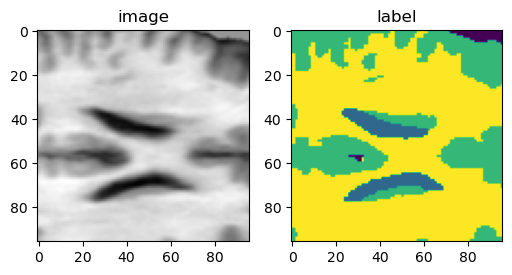

In [10]:
train_data_example = train_ds[0][0]
print(f"image shape: {train_data_example['image'].shape}")
print(f"image type: {train_data_example['image'].dtype}")
print(f"label shape: {train_data_example['label'].shape}")
print(f"label type: {train_data_example['label'].dtype}")
plt.figure("image", (6, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(train_data_example["image"].cpu().numpy()[0, :, :, ROI[2]//2], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(train_data_example["label"].cpu().numpy()[0, :, :, ROI[2]//2])
plt.show()

image shape: torch.Size([1, 256, 128, 256])
image type: torch.float32
label shape: torch.Size([1, 256, 128, 256])
label type: torch.float32


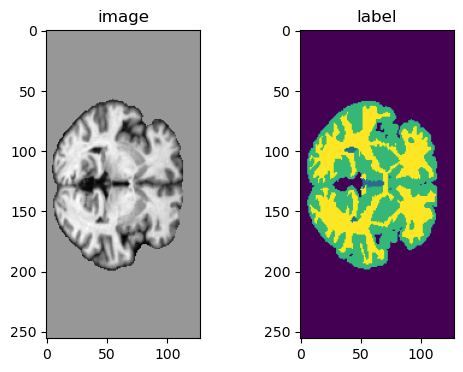

In [11]:
val_data_example = val_ds[0]
print(f"image shape: {val_data_example['image'].shape}")
print(f"image type: {val_data_example['image'].dtype}")
print(f"label shape: {val_data_example['label'].shape}")
print(f"label type: {val_data_example['label'].dtype}")
plt.figure("image", (6, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(val_data_example["image"].cpu().numpy()[0, :, :, IMG_SIZE[2]//2], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(val_data_example["label"].cpu().numpy()[0, :, :, IMG_SIZE[2]//2])
plt.show()

image shape: torch.Size([1, 256, 128, 256])
image type: torch.float32


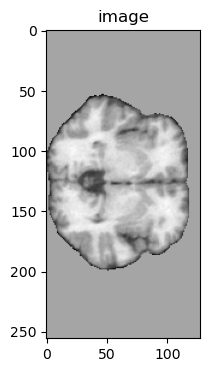

In [12]:
test_data_example = test_ds[0]
print(f"image shape: {test_data_example['image'].shape}")
print(f"image type: {test_data_example['image'].dtype}")
plt.figure("image", (6, 4))
plt.subplot(1, 1, 1)
plt.title("image")
plt.imshow(test_data_example["image"].cpu().numpy()[0, :, :, IMG_SIZE[2]//2], cmap="gray")
plt.show()

## Create Model, Loss, Optimizer

In [7]:
max_epochs = 1000
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create model, loss function and optimizer
device = torch.device("cuda:0")

# model = SegResNetDS(
#     blocks_down=[1, 2, 2, 4, 4],
#     dsdepth=1,
#     in_channels=1,
#     init_filters=32,
#     out_channels=NUM_CLASSES,
# ).to(device)
    
model = SwinUNETR(
    img_size=ROI,
    in_channels=1,
    out_channels=4,
    feature_size=48,
    use_checkpoint=True,
    use_v2=True,
).to(device)


loss_function = losses.DiceCELoss(to_onehot_y=True, softmax=True, squared_pred=True, include_background=True, smooth_nr=0, smooth_dr=1e-5)
optimizer = torch.optim.AdamW(model.parameters(), LR, weight_decay=1e-5)
lr_scheduler = optimizers.WarmupCosineSchedule(
    optimizer,
    t_total=max_epochs//val_interval+1,
    warmup_multiplier=0.1,
    warmup_steps=max_epochs//100
)

# define inference method
def inference(input):
    def _compute(input):
        roi_size = ROI
        sw_batch_size = NUM_PATCHES_PER_ITER
        return sliding_window_inference(input, roi_size, sw_batch_size, model, overlap=0.5)

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [14]:
import torchinfo

torchinfo.summary(model, input_size=(BATCH_SIZE_TRAIN, 1, ROI[0], ROI[1], ROI[2]))

Layer (type:depth-idx)                                  Output Shape              Param #
SwinUNETR                                               [4, 4, 96, 96, 96]        --
├─SwinTransformer: 1-1                                  [4, 48, 48, 48, 48]       --
│    └─PatchEmbed: 2-1                                  [4, 48, 48, 48, 48]       --
│    │    └─Conv3d: 3-1                                 [4, 48, 48, 48, 48]       432
│    └─Dropout: 2-2                                     [4, 48, 48, 48, 48]       --
│    └─ModuleList: 2-3                                  --                        --
│    │    └─UnetrBasicBlock: 3-2                        [4, 48, 48, 48, 48]       124,416
│    └─ModuleList: 2-4                                  --                        --
│    │    └─BasicLayer: 3-3                             [4, 96, 24, 24, 24]       107,358
│    └─ModuleList: 2-5                                  --                        --
│    │    └─UnetrBasicBlock: 3-4                 

## Setup Metrics and Early Stopper

In [15]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_metric = float('inf') if mode == 'min' else float('-inf')
        self.mode = mode

    def early_stop(self, validation_metric):
        if self.mode == 'min':
            improved = (validation_metric + self.min_delta) < self.best_metric
        else:
            improved = (validation_metric - self.min_delta) > self.best_metric

        if improved:
            self.best_metric = validation_metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
early_stopper = EarlyStopper(patience=PATIENCE, min_delta=1e-4, mode='max')

dice_metric = metrics.DiceMetric(include_background=True, reduction="mean_batch", get_not_nans=False)

## Execute a typical PyTorch training process

In [16]:
post_label = transforms.AsDiscrete(to_onehot=4)
post_pred = transforms.AsDiscrete(argmax=True, to_onehot=4)

best_avg_dice = -1

best_dice_epoch = -1

epoch_loss_values = []
lr_values = []

dice_avg_values = []
dice_wm_values = []
dice_gm_values = []
dice_csf_values = []

stop_training = False

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for train_data in train_loader:
        step_start = time.time()
        step += 1
        
        inputs_l = (
            train_data["image"].as_tensor()
            if isinstance(train_data["image"], data.MetaTensor)
            else train_data["image"]
        )
        labels_l = (
            train_data["label"].as_tensor()
            if isinstance(train_data["label"], data.MetaTensor)
            else train_data["label"]
        )

        _idx = torch.randperm(inputs_l.shape[0])
        inputs_l = inputs_l[_idx]
        labels_l = labels_l[_idx]

        loss_loop = []
        for _k in range(inputs_l.shape[0] // NUM_PATCHES_PER_ITER):
            inputs = inputs_l[_k * NUM_PATCHES_PER_ITER : (_k + 1) * NUM_PATCHES_PER_ITER, ...]
            labels = labels_l[_k * NUM_PATCHES_PER_ITER : (_k + 1) * NUM_PATCHES_PER_ITER, ...]

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # print(f"inputs shape: {inputs.shape}")
            # print(f"intput type: {type(inputs)}")
                    
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                # print(f"outputs type: {type(outputs)}")
                loss = loss_function(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            loss_loop.append(loss.item())
        
        # print(f"loss_loop type[0]: {type(loss_loop[0])}")
        # print(f"loss_loop[0]: {type(loss_loop[0])}")
        epoch_loss += np.mean(loss_loop)
        print(
            f"{epoch + 1}/{max_epochs}, "
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
        
    lr_values.append(lr_scheduler.get_last_lr()[0])
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1}, average loss: {epoch_loss:.4f}, lr: {lr_values[-1]:.6f}\n")
    tb_writer.add_scalar("epoch_train_loss", epoch_loss, epoch + 1)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_start = time.time()
        with torch.no_grad():
            for idx, val_data in enumerate(val_loader):
                
                val_inputs = (
                    val_data["image"].as_tensor()
                    if isinstance(val_data["image"], data.MetaTensor)
                    else val_data["image"]
                )
                val_labels = (
                    val_data["label"].as_tensor()
                    if isinstance(val_data["label"], data.MetaTensor)
                    else val_data["label"]
                )
                
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)

                val_outputs = inference(val_inputs)
                
                # print(f"val_outputs type: {type(val_outputs)}")
                # print(f"val_outputs shape: {val_outputs.shape}")
                # print(f"val_labels type: {type(val_labels)}")
                # print(f"val_labels shape: {val_labels.shape}")
                
                val_outputs_list = data.decollate_batch(val_outputs)
                val_labels_list = data.decollate_batch(val_labels)
                
                # print(f"val_outputs_list type: {type(val_outputs_list)}")
                # print(f"val_outputs_list len: {len(val_outputs_list)}")
                # print(f"val_outputs_list[0] type: {type(val_outputs_list[0])}")
                # print(f"val_outputs_list[0] shape: {val_outputs_list[0].shape}")
                
                # val_outputs_convert = [post_pred(post_sigmoid(val_output)) for val_output in val_outputs_list]
                val_outputs_convert = [post_pred(val_output) for val_output in val_outputs_list]
                val_labels_convert = [post_label(val_label) for val_label in val_labels_list]
                
                # print(f"val_outputs_convert type: {type(val_outputs_convert)}")
                # print(f"val_outputs_convert len: {len(val_outputs_convert)}")
                # print(f"val_outputs_convert[0] type: {type(val_outputs_convert[0])}")
                # print(f"val_outputs_convert[0] shape: {val_outputs_convert[0].shape}")
                
                dice_metric(val_outputs_convert, val_labels_convert)
                    
                print(
                    f"val {epoch + 1}/{max_epochs}, {idx + 1}/{len(val_loader)}",
                    f", time {(time.time() - val_start):.4f}s",
                )
                val_start = time.time()
                
            dice_all = dice_metric.aggregate()
            # print(dice_all)
            # print(f"dice_all type: {type(dice_all)}"
            #         f"\ndice_all shape: {dice_all.shape}")
            dice_bg = dice_all[BG_LABEL].item()
            dice_wm = dice_all[WM_LABEL].item()
            dice_gm = dice_all[GM_LABEL].item()
            dice_csf = dice_all[CSF_LABEL].item()
            dice_avg = torch.mean(dice_all[1:]).item()
            dice_metric.reset()
            
            dice_avg_values.append(dice_avg)
            dice_wm_values.append(dice_wm)
            dice_gm_values.append(dice_gm)
            dice_csf_values.append(dice_csf)
            
            tb_writer.add_scalar("epoch_val_dice_avg", dice_avg, epoch + 1)
            tb_writer.add_scalar("epoch_val_dice_bg", dice_bg, epoch + 1)
            tb_writer.add_scalar("epoch_val_dice_wm", dice_wm, epoch + 1)
            tb_writer.add_scalar("epoch_val_dice_gm", dice_gm, epoch + 1)
            tb_writer.add_scalar("epoch_val_dice_csf", dice_csf, epoch + 1)
            tb_writer.add_scalar("learning_rate", lr_values[-1], epoch + 1)
            

            if dice_avg > best_avg_dice:
                best_avg_dice = dice_avg
                best_dice_epoch = epoch + 1
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("\n=> SAVED NEW BEST MODEL!")

            print(
                f"\nCURRENT epoch: {epoch + 1}"
                f"\nCURRENT avg dice: {dice_avg:.4f}"
                f"\nCURRENT wm dice: {dice_wm:.4f}"
                f"\nCURRENT gm dice: {dice_gm:.4f}"
                f"\nCURRENT csf dice: {dice_csf:.4f}"
                
                f"\n"
                
                f"\nBEST avg dice: {best_avg_dice:.4f} at epoch: {best_dice_epoch}"
            )
            
            if early_stopper.early_stop(dice_avg) and PATIENCE > 0:             
                print("\n=> EARLY STOPPING")
                stop_training = True
                break
            
    print(f"\ntime consuming of epoch {epoch + 1} is: {str(datetime.timedelta(seconds=int((time.time() - epoch_start))))}")
    
    if stop_training:
        break
    
total_time = time.time() - total_start

----------
epoch 1/1000
1/1000, 1/2, train_loss: 1.8480, step time: 12.0460
1/1000, 2/2, train_loss: 1.5102, step time: 5.1204
1/1000, 3/2, train_loss: 1.3687, step time: 2.5663
epoch 1, average loss: 1.6561, lr: 0.000020

val 1/1000, 1/3 , time 16.4554s
val 1/1000, 2/3 , time 9.6437s
val 1/1000, 3/3 , time 4.8332s

=> SAVED NEW BEST MODEL!

CURRENT epoch: 1
CURRENT avg dice: 0.3677
CURRENT wm dice: 0.6419
CURRENT gm dice: 0.4489
CURRENT csf dice: 0.0122

BEST avg dice: 0.3677 at epoch: 1

time consuming of epoch 1 is: 0:01:10
----------
epoch 2/1000
2/1000, 1/2, train_loss: 1.3612, step time: 5.4063
2/1000, 2/2, train_loss: 1.1520, step time: 5.1136
2/1000, 3/2, train_loss: 1.0041, step time: 2.5651
epoch 2, average loss: 1.2239, lr: 0.000038

val 2/1000, 1/3 , time 16.6686s
val 2/1000, 2/3 , time 9.6481s
val 2/1000, 3/3 , time 4.8387s

=> SAVED NEW BEST MODEL!

CURRENT epoch: 2
CURRENT avg dice: 0.4710
CURRENT wm dice: 0.7727
CURRENT gm dice: 0.5131
CURRENT csf dice: 0.1270

BEST avg

KeyboardInterrupt: 

In [18]:
total_time_formatted = str(datetime.timedelta(seconds=int(total_time)))

print(f"training completed, best_avg_dice: {best_avg_dice:.4f} at epoch: {best_dice_epoch}, total time: {total_time_formatted}.")

training completed, best_avg_dice: 0.8711 at epoch: 111, total time: 3:05:30.


## Evaluate

In [8]:
other_dir = "D:\\Files\\Projects\\MAIA\\UdG\\MISA\\Project\\experiments\\exp02-SwinUNETR_v2-20231230_21_03_40"
model.load_state_dict(torch.load(os.path.join(other_dir, "best_metric_model.pth")))
model.to(device)
model.eval()

y_true = []
y_pred = []

infer_transform = transforms.AsDiscrete(argmax=True)

val_start = time.time()
with torch.no_grad():
    for idx, val_data in enumerate(val_loader):
        
        val_inputs = (
            val_data["image"].as_tensor()
            if isinstance(val_data["image"], data.MetaTensor)
            else val_data["image"]
        )
        val_labels = (
            val_data["label"].as_tensor()
            if isinstance(val_data["label"], data.MetaTensor)
            else val_data["label"]
        )
        
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)

        val_outputs = inference(val_inputs)
        
        val_outputs_list = data.decollate_batch(val_outputs)
        val_labels_list = data.decollate_batch(val_labels)
        
        val_outputs_convert = [infer_transform(val_output) for val_output in val_outputs_list]
        val_labels_convert = val_labels_list
                    
        print(
            f"infer {idx + 1}/{len(val_loader)}",
            f", time {(time.time() - val_start):.4f}s",
        )
        val_start = time.time()
                
        for i in range(len(val_outputs_convert)):
            y_true.append(val_labels_convert[i].cpu().numpy())
            y_pred.append(val_outputs_convert[i].cpu().numpy())

infer 1/3 , time 22.1118s
infer 2/3 , time 9.3795s
infer 3/3 , time 4.8306s


y_true[0] type: <class 'numpy.ndarray'>
y_true[0] shape: (1, 256, 128, 256)
y_true[0] dtype: float32
y_pred[0] type: <class 'numpy.ndarray'>
y_pred[0] shape: (1, 256, 128, 256)
y_pred[0] dtype: float32


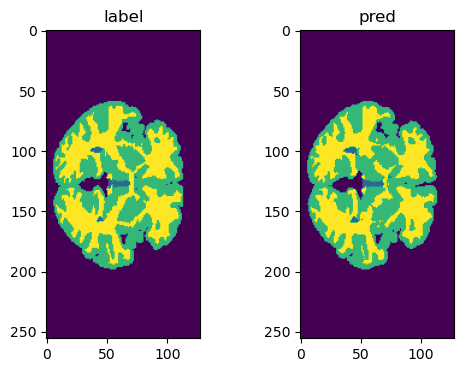

In [9]:
# plot first label and pred
print(f"y_true[0] type: {type(y_true[0])}")
print(f"y_true[0] shape: {y_true[0].shape}")
print(f"y_true[0] dtype: {y_true[0].dtype}")
print(f"y_pred[0] type: {type(y_pred[0])}")
print(f"y_pred[0] shape: {y_pred[0].shape}")
print(f"y_pred[0] dtype: {y_pred[0].dtype}")
plt.figure("label", (6, 4))
plt.subplot(1, 2, 1)
plt.title("label")
plt.imshow(y_true[0][0, :, :, IMG_SIZE[2]//2])
plt.subplot(1, 2, 2)
plt.title("pred")
plt.imshow(y_pred[0][0, :, :, IMG_SIZE[2]//2])
plt.show()

In [10]:
def calculate_dice_score(labels_seg, labels_gt, print_score=True):
    dice_score = {}
    
    # please check what are the actual label values for the dataset you are working with

    label_seg_csf = labels_seg == 1
    label_seg_gm = labels_seg == 2
    label_seg_wm = labels_seg == 3

    label_gt_csf = labels_gt == 1
    label_gt_gm = labels_gt == 2
    label_gt_wm = labels_gt == 3

    dice_score['csf'] = np.sum(label_gt_csf[label_seg_csf]) * 2.0 / (np.sum(label_gt_csf) + np.sum(label_seg_csf))
    dice_score['gm'] = np.sum(label_gt_gm[label_seg_gm]) * 2.0 / (np.sum(label_gt_gm) + np.sum(label_seg_gm))
    dice_score['wm'] = np.sum(label_gt_wm[label_seg_wm]) * 2.0 / (np.sum(label_gt_wm) + np.sum(label_seg_wm))

    if print_score:
        print('Dice scores:')
        for key, value in dice_score.items():
            print(f'{key}: {value:.4f}')
            
        print(f'Average: {np.mean(list(dice_score.values())):.4f}')

    return dice_score

In [11]:
import SimpleITK as sitk

def calculate_hausdorff_distance(labels_pred, labels_gt, print_score=True):
    """
    Calculate the Hausdorff distance for each label in the predicted and ground truth segmentation.

    Parameters
    ----------
    labels_pred : numpy array
        Predicted segmentation labels.
    labels_gt : numpy array
        Ground truth segmentation labels.
    print_score : bool, optional
        Whether to print the Hausdorff distance for each label, by default True.

    Returns
    -------
    hd_score : dict
        Dictionary containing the Hausdorff distance for each label.
    """
    # Convert numpy arrays to SimpleITK images
    pred_image = sitk.GetImageFromArray(labels_pred)
    gt_image = sitk.GetImageFromArray(labels_gt)

    # Create the Hausdorff distance filter
    hd_filter = sitk.HausdorffDistanceImageFilter()

    # Calculate the Hausdorff distance for each label
    hd_scores = {}
    for label, label_name in zip([1, 2, 3], ['csf', 'gm', 'wm']):
        pred_label = sitk.BinaryThreshold(pred_image, label, label)
        gt_label = sitk.BinaryThreshold(gt_image, label, label)

        hd_filter.Execute(pred_label, gt_label)
        hd_scores[label_name] = hd_filter.GetHausdorffDistance()
    
    if print_score:
        print('Hausdorff distance:')
        for key, value in hd_scores.items():
            print(f'{key}: {value:.4f}')
        
        print(f'Average: {np.mean(list(hd_scores.values())):.4f}')

    return hd_scores

In [12]:
def calculate_avd(pred_labels, gt_labels, print_scores=True):
    """
    Calculate the average volumetric difference (AVD) per label between predicted and ground truth labels.

    Parameters
    ----------
    pred_labels : numpy.ndarray
        Predicted segmentation labels.
    gt_labels : numpy.ndarray
        Ground truth segmentation labels.
    print_scores : bool, optional
        Whether to print the AVD scores per label, by default True.

    Returns
    -------
    avd_scores : dict
        Dictionary containing the average volumetric difference (AVD) score per label.
    """
    avd_scores = {}
    
    for label, label_name in zip([1, 2, 3], ['csf', 'gm', 'wm']):
        pred_label = pred_labels == label
        gt_label = gt_labels == label

        avd_scores[label_name] = np.abs(np.sum(pred_label) - np.sum(gt_label)) / np.sum(gt_label)

    if print_scores:
        print("Average Volumetric Difference (AVD) per label:")
        for label, score in avd_scores.items():
            print(f"Label {label}: {score:.4f}")
            
        print(f"Average: {np.mean(list(avd_scores.values())):.4f}")

    return avd_scores

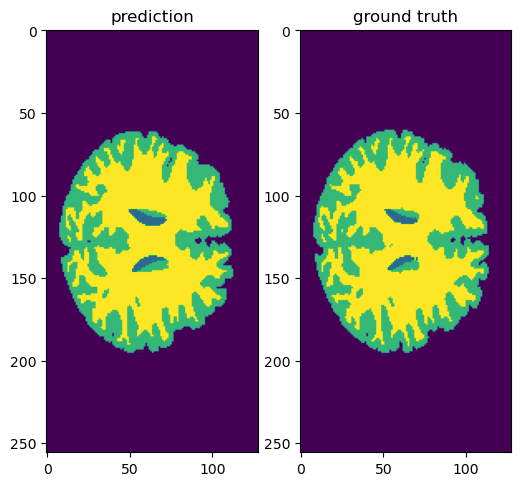

Dice scores:
csf: 0.8760
gm: 0.7477
wm: 0.8892
Average: 0.8376

Hausdorff distance:
csf: 135.7792
gm: 130.7020
wm: 127.7263
Average: 131.4025

Average Volumetric Difference (AVD) per label:
Label csf: 0.0504
Label gm: 0.4479
Label wm: 0.1121
Average: 0.2035


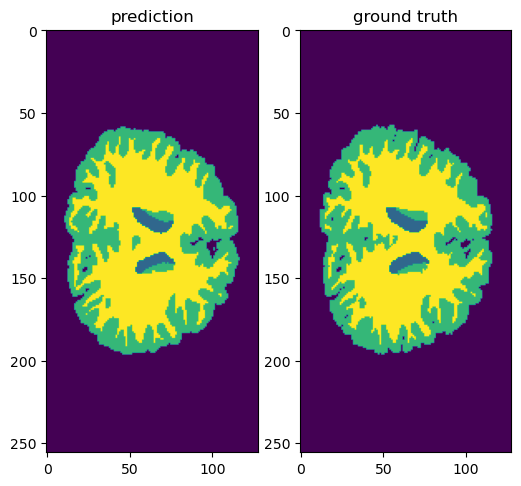

Dice scores:
csf: 0.9056
gm: 0.7379
wm: 0.8781
Average: 0.8405

Hausdorff distance:
csf: 139.7891
gm: 133.9963
wm: 132.3669
Average: 135.3841

Average Volumetric Difference (AVD) per label:
Label csf: 0.0573
Label gm: 0.4753
Label wm: 0.1940
Average: 0.2422


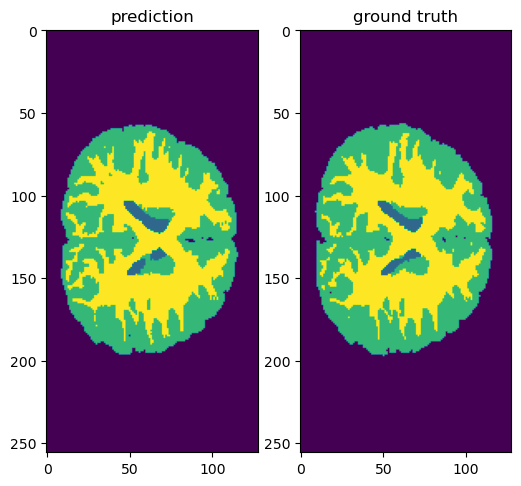

Dice scores:
csf: 0.8695
gm: 0.8328
wm: 0.8599
Average: 0.8541

Hausdorff distance:
csf: 134.5548
gm: 129.2633
wm: 130.5795
Average: 131.4659

Average Volumetric Difference (AVD) per label:
Label csf: 0.0172
Label gm: 0.1193
Label wm: 0.2082
Average: 0.1149


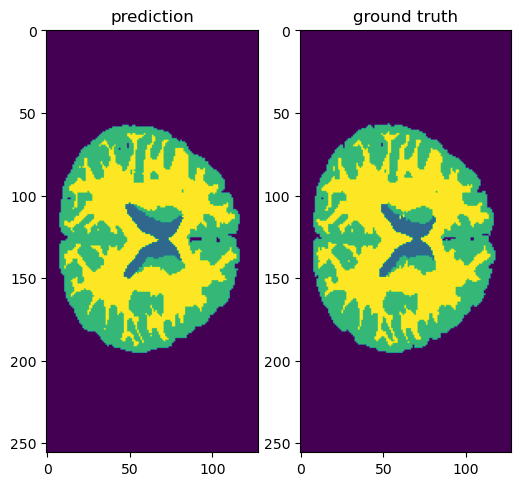

Dice scores:
csf: 0.9088
gm: 0.9039
wm: 0.9183
Average: 0.9103

Hausdorff distance:
csf: 13.6382
gm: 129.7074
wm: 124.1169
Average: 89.1541

Average Volumetric Difference (AVD) per label:
Label csf: 0.1122
Label gm: 0.0920
Label wm: 0.0284
Average: 0.0775


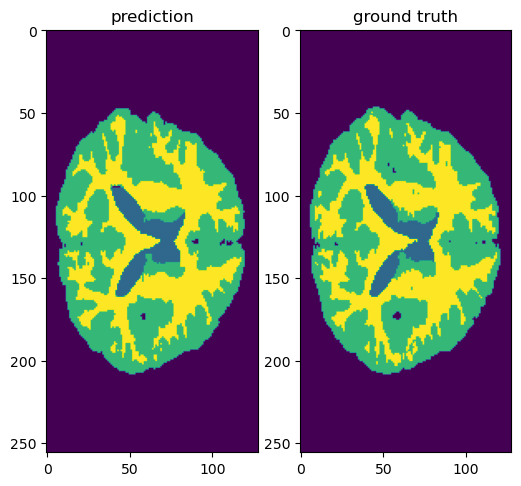

Dice scores:
csf: 0.9181
gm: 0.9006
wm: 0.9201
Average: 0.9129

Hausdorff distance:
csf: 18.1384
gm: 119.5324
wm: 116.5333
Average: 84.7347

Average Volumetric Difference (AVD) per label:
Label csf: 0.0385
Label gm: 0.0356
Label wm: 0.0057
Average: 0.0266

##################################################
AVERAGE SCORES FOR ALL CASES
##################################################

Average dice scores for all cases:
csf: 0.8956
gm: 0.8246
wm: 0.8931
Total average: 0.8711

Average Hausdorff scores for all cases:
csf: 88.3799
gm: 128.6403
wm: 126.2646
Total average: 114.4283

Average AVD scores for all cases:
csf: 0.0551
gm: 0.2340
wm: 0.1097
Total average: 0.1329


In [13]:
dice_scores = []
hd_scores = []
avd_scores = []

for i in range(len(y_true)):
    # squeeze the channel dimension
    y_true[i] = np.squeeze(y_true[i])
    y_pred[i] = np.squeeze(y_pred[i])
    
    # plot the data
    plt.figure("check", (6, 6))
    plt.subplot(1, 2, 1)
    plt.title("prediction")
    plt.imshow(y_pred[i][:, :, 150])
    plt.subplot(1, 2, 2)
    plt.title("ground truth")
    plt.imshow(y_true[i][:, :, 150])
    plt.show()
    
    dice_scores.append(calculate_dice_score(y_pred[i], y_true[i]))
    print()
    hd_scores.append(calculate_hausdorff_distance(y_pred[i], y_true[i]))
    print()
    avd_scores.append(calculate_avd(y_pred[i], y_true[i]))
    
print()
print("#" * 50)
print("AVERAGE SCORES FOR ALL CASES")
print("#" * 50)

# calculate the average for csf, gm, and wm for dice scores
print("\nAverage dice scores for all cases:")
average_dice_score = {}
for key in dice_scores[0].keys():
    average_dice_score[key] = np.mean([dice_score[key] for dice_score in dice_scores])
for key, value in average_dice_score.items():
    print(f"{key}: {value:.4f}")
print(f"Total average: {np.mean(list(average_dice_score.values())):.4f}")

# calculate the average for csf, gm, and wm for Hausdorff scores
print("\nAverage Hausdorff scores for all cases:")
average_hd_score = {}
for key in hd_scores[0].keys():
    average_hd_score[key] = np.mean([hd_score[key] for hd_score in hd_scores])
for key, value in average_hd_score.items():
    print(f"{key}: {value:.4f}")
print(f"Total average: {np.mean(list(average_hd_score.values())):.4f}")

# calculate the average for csf, gm, and wm for AVD scores
print("\nAverage AVD scores for all cases:")
average_avd_score = {}
for key in avd_scores[0].keys():
    average_avd_score[key] = np.mean([avd_score[key] for avd_score in avd_scores])
for key, value in average_avd_score.items():
    print(f"{key}: {value:.4f}")
print(f"Total average: {np.mean(list(average_avd_score.values())):.4f}")

In [14]:
# create a dataframe with all the scores, both per case and average
import pandas as pd

val_cases_orig = [11, 12, 13, 14, 17]

df_dice_orig = pd.DataFrame(dice_scores)
df_dice = df_dice_orig.copy()
df_dice['average'] = df_dice_orig.mean(axis=1)
df_dice['std'] = df_dice_orig.std(axis=1)

df_hausdorff_orig = pd.DataFrame(hd_scores)
df_hausdorff = df_hausdorff_orig.copy()
df_hausdorff['average'] = df_hausdorff_orig.mean(axis=1)
df_hausdorff['std'] = df_hausdorff_orig.std(axis=1)

df_avd_orig = pd.DataFrame(avd_scores)
df_avd = df_avd_orig.copy()
df_avd['average'] = df_avd_orig.mean(axis=1)
df_avd['std'] = df_avd_orig.std(axis=1)

df_scores = pd.concat([df_dice, df_hausdorff, df_avd], axis=1)
df_scores.index = val_cases_orig

# rename the columns
df_scores.columns = [
    'dice_csf', 'dice_gm', 'dice_wm', 'dice_average', 'dice_std',
    'hd', 'hd_gm', 'hd_wm', 'hd_average', 'hd_std',
    'avd_csf', 'avd_gm', 'avd_wm', 'avd_average', 'avd_std'
]

# export to excel
df_scores.to_excel('results/exp02_scores.xlsx')

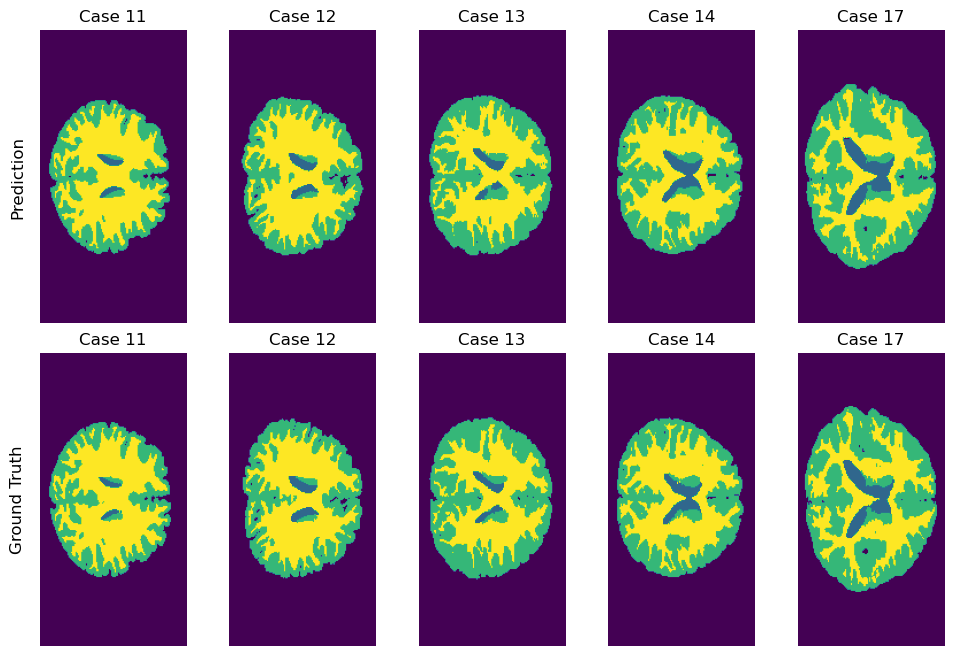

In [15]:
import matplotlib.pyplot as plt

n_slice = 150

# Create subplots with 3 rows and the number of columns based on the number of images
fig, axes = plt.subplots(2, len(y_true), figsize=(12, 8))

# Add vertical text to indicate original, prediction, and ground truth
axes[0, 0].text(-20, 128, "Prediction", rotation="vertical", va="center", ha="center", fontsize=12)
axes[1, 0].text(-20, 128, "Ground Truth", rotation="vertical", va="center", ha="center", fontsize=12)

# Plot predictions
for i in range(len(y_pred)):
    axes[0, i].imshow(y_pred[i][:, :, n_slice])
    axes[0, i].set_title(f"Case {val_cases_orig[i]}")
    axes[0, i].axis("off")

# Plot ground truth
for i in range(len(y_true)):
    axes[1, i].imshow(y_true[i][:, :, n_slice])
    axes[1, i].set_title(f"Case {val_cases_orig[i]}")
    axes[1, i].axis("off")

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()